In [28]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import sys
import os

# Adiciona o diretório pai (a raiz do projeto) ao 'sys.path'
# '..' significa "subir um nível"
project_root = os.path.abspath('..')

# Adiciona o caminho apenas se ele ainda não estiver lá
if project_root not in sys.path:
    sys.path.append(project_root)

# Agora esta linha deve funcionar!
from config import settings
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np

pd.options.display.float_format = '{:.2f}'.format

# Leitura dos Dados

In [2]:
dados_dict = {}

# 1. Usar 'with open' para abrir e fechar o arquivo automaticamente
# 'r' significa modo de leitura (read)
try:
    with open(settings.APIFY_JSON_OUT, 'r', encoding='utf-8') as arquivo:
        # 2. Usar json.load() para ler o arquivo e converter para dict
        dados_dict = json.load(arquivo)

    df_deputados = pd.read_json(settings.APIFY_JSON_OUT, orient='records')

except FileNotFoundError:
    print(f"Erro: O arquivo '{settings.APIFY_CSV_OUT}' não foi encontrado.")
except json.JSONDecodeError:
    print(f"Erro: O arquivo '{settings.APIFY_CSV_OUT}' não é um JSON válido.")

In [3]:
list_of_post_dataframes = []

for registro in dados_dict:
    # Check if the key exists AND if the value is not empty (for safety)
    if 'latestPosts' in registro and registro['latestPosts']:
        
        posts = registro['latestPosts']
        
        for post in posts:
            post['inputUrl'] = registro['inputUrl']
        
        df_posts = pd.DataFrame(posts)
        list_of_post_dataframes.append(df_posts)

# 1. Concatenate all DataFrames in the list into one master DataFrame
# 'ignore_index=True' is used to reset the index of the resulting DataFrame
df_posts_total = pd.concat(list_of_post_dataframes, ignore_index=True)

# 2. Convert the 'timestamp' column to datetime objects
# Assuming 'timestamp' is in seconds (a common format for API timestamps)
df_posts_total['data_datetime'] = pd.to_datetime(df_posts_total['timestamp'])

In [4]:
df_deputados.columns

Index(['inputUrl', 'id', 'username', 'url', 'fullName', 'biography',
       'externalUrls', 'externalUrl', 'externalUrlShimmed', 'followersCount',
       'followsCount', 'hasChannel', 'highlightReelCount', 'isBusinessAccount',
       'joinedRecently', 'businessCategoryName', 'private', 'verified',
       'profilePicUrl', 'profilePicUrlHD', 'igtvVideoCount', 'relatedProfiles',
       'latestIgtvVideos', 'postsCount', 'latestPosts', 'fbid',
       'businessAddress', 'error', 'errorDescription', 'isRestrictedProfile',
       'restrictionReason'],
      dtype='object')

# Cálculo de Estatísticas

In [5]:
df_posts_agrupado = df_posts_total.groupby('inputUrl').agg(
    commentsCount=('commentsCount', 'sum'),
    likesCount=('likesCount', 'sum'),
    videoViewCount=('videoViewCount', 'sum'),
    post_count=('id', 'count'),
    data_datetime_max=('data_datetime', 'max'),
    data_datetime_min=('data_datetime', 'min'),
).reset_index()

In [6]:
df_deputados_join = pd.merge(df_deputados, df_posts_agrupado, how='left', on='inputUrl')

df_deputados_join['% Engajamento'] = (df_deputados_join['likesCount'] + df_deputados_join['commentsCount']) / df_deputados_join['followersCount']

df_deputados_join['% commentsCount'] = df_deputados_join['commentsCount'] / df_deputados_join['followersCount']

df_deputados_join['% likesCount'] = df_deputados_join['likesCount'] / df_deputados_join['followersCount']

df_deputados_join['likesCount\Posts'] = df_deputados_join['likesCount'] / df_deputados_join['post_count']

df_deputados_join['commentsCount\Posts'] = df_deputados_join['commentsCount'] / df_deputados_join['post_count']

# 1. Calcular o período em dias que os posts de cada deputado cobrem
periodo_dias = (df_deputados_join['data_datetime_max'] - df_deputados_join['data_datetime_min']).dt.days

# 2. Calcular a frequência (ex: posts por dia)
# Adicionamos +1 para evitar divisão por zero se todos os posts foram no mesmo dia
df_deputados_join['Frequencia (Posts/Dia)'] = df_deputados_join['post_count'] / (periodo_dias + 1)

# Ou, se preferir (dias por post):
df_deputados_join['Frequencia (Dias/Post)'] = periodo_dias / df_deputados_join['post_count']

<>:9: SyntaxWarning: invalid escape sequence '\P'
<>:11: SyntaxWarning: invalid escape sequence '\P'
<>:9: SyntaxWarning: invalid escape sequence '\P'
<>:11: SyntaxWarning: invalid escape sequence '\P'
C:\Users\user\AppData\Local\Temp\ipykernel_17556\3852323409.py:9: SyntaxWarning: invalid escape sequence '\P'
  df_deputados_join['likesCount\Posts'] = df_deputados_join['likesCount'] / df_deputados_join['post_count']
C:\Users\user\AppData\Local\Temp\ipykernel_17556\3852323409.py:11: SyntaxWarning: invalid escape sequence '\P'
  df_deputados_join['commentsCount\Posts'] = df_deputados_join['commentsCount'] / df_deputados_join['post_count']


# Analise Descritiva Geral

## Estatísticas Univariadas

In [7]:
cols = ['followersCount', 'followsCount', 'postsCount', 'videoViewCount', 
        '% Engajamento', 'Frequencia (Posts/Dia)', 'Frequencia (Dias/Post)', 'likesCount', '% likesCount', 'likesCount\Posts',
        'commentsCount', '% commentsCount', 'commentsCount\Posts']

cols_base = ['followersCount', 'followsCount', 'postsCount', 'videoViewCount', '% Engajamento', 
             'Frequencia (Posts/Dia)', 'Frequencia (Dias/Post)']

cols_like = ['likesCount', '% likesCount', 'likesCount\Posts']

cols_comments = ['commentsCount', '% commentsCount', 'commentsCount\Posts']

<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:3: SyntaxWarning: invalid escape sequence '\P'
<>:8: SyntaxWarning: invalid escape sequence '\P'
<>:10: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:3: SyntaxWarning: invalid escape sequence '\P'
<>:8: SyntaxWarning: invalid escape sequence '\P'
<>:10: SyntaxWarning: invalid escape sequence '\P'
C:\Users\user\AppData\Local\Temp\ipykernel_17556\2535165801.py:2: SyntaxWarning: invalid escape sequence '\P'
  '% Engajamento', 'Frequencia (Posts/Dia)', 'Frequencia (Dias/Post)', 'likesCount', '% likesCount', 'likesCount\Posts',
C:\Users\user\AppData\Local\Temp\ipykernel_17556\2535165801.py:3: SyntaxWarning: invalid escape sequence '\P'
  'commentsCount', '% commentsCount', 'commentsCount\Posts']
C:\Users\user\AppData\Local\Temp\ipykernel_17556\2535165801.py:8: SyntaxWarning: invalid escape sequence '\P'
  cols_like = ['likesCount', '% likesCount', 'likesCount\Posts']
C:\Users\user\AppData

In [8]:
df_deputados_join[cols_base].describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

,followersCount,followsCount,postsCount,videoViewCount,% Engajamento,Frequencia (Posts/Dia),Frequencia (Dias/Post)
count,254.00,254.00,254.00,254.00,254.00,254.00,254.00
mean,351693.96,3798.61,5254.81,1002296.61,0.34,0.94,11.44
std,1294172.06,2333.89,4825.41,8827964.25,0.67,1.34,18.58
min,6795.00,138.00,226.00,484.00,0.01,0.01,0.00
1%,12148.47,239.84,768.64,1002.23,0.02,0.01,0.08
10%,21103.50,1040.90,1664.60,5077.00,0.04,0.03,0.33
25%,32398.25,1797.00,2583.25,13731.75,0.07,0.07,0.67
50%,69728.50,3317.00,4072.00,41037.00,0.13,0.43,2.25
75%,204765.50,5856.50,6398.00,341758.25,0.28,1.33,14.81
90%,666996.30,7355.40,9690.60,1283295.40,0.75,2.40,37.99


A presente análise estatística descritiva investiga o desempenho digital de 254 deputados federais brasileiros na plataforma Instagram, com base em métricas de audiência, atividade e engajamento. O achado central que permeia todas as variáveis analisadas é a heterogeneidade extrema dos dados. Observa-se uma assimetria positiva (à direita) muito acentuada em quase todas as métricas, onde a média aritmética é consistentemente e significativamente superior à mediana (percentil 50). Isso indica que, para todas as variáveis de desempenho, a maioria dos deputados apresenta resultados modestos (abaixo da média), enquanto um grupo muito restrito de parlamentares (outliers positivos) detém números extraordinariamente elevados, distorcendo fortemente o valor médio e demonstrando uma concentração massiva de capital político-digital.

Ao analisar a variável `followersCount` (número de seguidores), a disparidade é patente. A média de seguidores é de 351.693,96, um valor robusto. Contudo, a mediana é de apenas 69.728,50. Esta discrepância revela que 50% dos deputados possuem menos de 70 mil seguidores, um número substancialmente inferior à média. A média é inflada por uma "cauda longa" de perfis com alta performance: o P90 (percentil 90) mostra que 10% dos deputados possuem mais de 666.996 seguidores, e o P99 (percentil 99) salta para mais de 3 milhões (3.099.808,78). O desvio padrão (std) de 1.294.172,06, sendo quase quatro vezes o valor da média, confirma a variabilidade extrema. O valor máximo de 18.655.198,00 é um outlier extremo, demonstrando que a audiência digital na Câmara dos Deputados é um jogo de "superestrelas", onde a grande maioria possui uma base de audiência pequena ou média.

A análise da atividade da conta, medida por `followsCount` (perfis seguidos) e `postsCount` (total de publicações), também revela estratégias distintas. A mediana de `followsCount` é de 3.317,00, com um desvio padrão de 2.333,89. O P99 (7.498,47) e o máximo (7.500,00) indicam que o 1% superior dos deputados atinge o limite técnico da plataforma, sugerindo uma estratégia de "seguir de volta" ou "seguir em massa" para estimular o crescimento. Em relação ao `postsCount`, a média de 5.254,81 publicações é superior à mediana de 4.072,00. O 1% mais ativo (P99) possui mais de 26.282 publicações, enquanto o máximo atinge 47.277,00. Isso mostra que, enquanto metade dos deputados mantém um ritmo de publicação (total histórico) abaixo de 4 mil posts, uma pequena fração utiliza a plataforma de forma hiperativa, quase como um veículo de imprensa.

A métrica `videoViewCount` (visualizações de vídeo) apresenta a assimetria mais dramática de todo o conjunto de dados. A média de visualizações é de 10.022.96,61 (mais de 10 milhões), enquanto a mediana é de apenas 41.037,00. O desvio padrão de 88.279.64,25 é quase nove vezes maior que a média. Este cenário indica que o desempenho de vídeo é estatisticamente irrelevante para 50% da amostra (que não atinge 42 mil visualizações somadas). O desempenho médio é inteiramente definido pelo 1% superior (P99), que registra mais de 82,2 milhões de visualizações, e pelo valor máximo de quase 140 milhões. Conclui-se que a viralização e o alcance massivo através de vídeos (como Reels) são fenômenos restritos a um grupo minúsculo de deputados, provavelmente aqueles que já possuem as maiores bases de seguidores.

A taxa de `% Engajamento`, calculada como a soma de curtidas e comentários dividida pelo número de seguidores, apresenta um cenário de baixa reatividade geral. A média de 0,34% (ou 0.0034) e a mediana de 0,13% (ou 0.0013) são baixas. O intervalo interquartil (IIQ), que representa os 50% centrais dos dados, situa-se entre 0,07% (Q1) e 0,28% (Q3). Isso significa que 75% dos deputados federais não conseguem sequer 0,3% de engajamento em suas publicações. Novamente, a média é mais que o dobro da mediana, puxada pelos perfis de melhor desempenho. O P99 (3,52%) e o máximo (5,58%) mostram que o 1% superior consegue um engajamento (acima de 3,5%) que é mais de 27 vezes superior ao engajamento do deputado mediano (0,13%).

A análise da `Frequencia (Posts/Dia)` revela uma inconsistência estratégica na manutenção dos perfis. A média é de 0,94 (quase um post por dia), mas a mediana é de apenas 0,43 (menos de um post a cada dois dias). O desvio padrão (1.34) é maior que a média, indicando alta variabilidade. O primeiro quartil (Q1) é de 0,07, mostrando que 25% dos deputados postam com uma frequência muito baixa. Em contrapartida, os 10% mais ativos (P90) postam mais de 2,4 vezes ao dia, e o 1% superior (P99) ultrapassa 6 posts diários. O máximo de 12 posts por dia sugere uma estratégia de saturação de feed, comparável a um portal de notícias, adotada por pouquíssimos parlamentares.

A métrica `Frequencia (Dias/Post)`, que funciona como o inverso da anterior, ilustra o nível de abandono ou uso esporádico da plataforma por parte de alguns deputados. A mediana de 2,25 dias (intervalo entre posts para o deputado mediano) contrasta agudamente com a média de 11,44 dias. A média é inflada por uma longa cauda de inatividade. O terceiro quartil (Q3) de 14,81 dias e o P90 de 37,99 dias são alarmantes: indicam que pelo menos 25% dos deputados postam, em média, com intervalos superiores a duas semanas, e 10% postam menos de uma vez por mês. O valor máximo de 93,33 dias (P99 é 81,58) mostra perfis praticamente inativos ou abandonados.

Em síntese, os dados descritivos dos 254 deputados federais revelam que a média não é uma medida representativa para este universo. A performance no Instagram é caracterizada por uma concentração extrema de audiência (`followersCount`) e visibilidade (`videoViewCount`) nas mãos de poucos parlamentares (o 1% ou 10% superiores). Para a vasta maioria (representada pela mediana e pelo Q1), a plataforma é um território de baixa audiência, engajamento muito baixo (mediana de 0,13%) e atividade inconsistente, com uma parcela significativa (pelo menos 10%) tratando a plataforma como um canal secundário, com longos intervalos entre publicações.

In [9]:
df_deputados_join[cols_like].describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

,likesCount,% likesCount,likesCount\Posts
count,254.00,254.00,254.00
mean,202591.97,0.31,16882.66
std,1756672.87,0.62,146389.41
min,466.00,0.01,38.83
1%,717.17,0.02,59.76
10%,1590.90,0.04,132.57
25%,2682.75,0.06,223.56
50%,5781.50,0.12,481.79
75%,51980.25,0.25,4331.69
90%,285292.20,0.72,23774.35


Esta segunda fase da análise aprofunda a investigação sobre o desempenho dos 254 deputados federais, focando especificamente nas métricas derivadas de `likesCount` (curtidas). Os resultados aqui apresentados não apenas corroboram, mas intensificam as conclusões da análise anterior: o ecossistema digital da Câmara dos Deputados no Instagram é um ambiente de disparidade estatística extrema, onde a performance média é uma métrica distorcida e estatisticamente pouco representativa da realidade da maioria dos parlamentares. A assimetria positiva (à direita) é a característica dominante em todas as variáveis analisadas, indicando que um grupo muito restrito de deputados concentra a vasta maioria do capital de engajamento (curtidas).

A análise da variável `likesCount` (volume total de curtidas) expõe essa disparidade de forma contundente. A média de curtidas totalizadas é de 202.591,97. No entanto, a mediana (percentil 50) é de apenas 5.781,50. Esta diferença abissal, onde a média é aproximadamente 35 vezes maior que a mediana, demonstra que 50% dos deputados federais acumulam menos de 5.800 curtidas (no período analisado), enquanto o valor médio é inflacionado por outliers extremos. O desvio padrão (std) de 1.756.672,87 é astronômico, sendo 8,7 vezes superior ao próprio valor da média, o que sinaliza uma variabilidade tão extrema que torna a média quase inutilizável para descrever o deputado "típico".

A distribuição de `likesCount` revela a profunda concentração de desempenho. O primeiro quartil (Q1) é de 2.682,75, indicando que 25% dos parlamentares possuem um volume de curtidas muito baixo. O terceiro quartil (Q3) de 51.980,25 mostra que 75% da amostra não alcança 52 mil curtidas. Em contrapartida, o topo da pirâmide opera em outra realidade: o percentil 90 (P90) salta para 285.292,20 (superando a média), o P99 atinge 1.658.754,70, e o valor máximo alcança impressionantes 27.808.539,00. Fica evidente que o desempenho em curtidas é um fenômeno de "superestrelas", onde o 1% superior acumula ordens de magnitude a mais de engajamento que os 75% inferiores.

A métrica `% likesCount` (curtidas divididas pelo número de seguidores) normaliza o desempenho pela audiência, fornecendo uma taxa de engajamento relativo. Aqui, a média é de 0,31% e a mediana é de 0,12%. Embora a disparidade seja menor que nas métricas absolutas, a média ainda é 2,5 vezes maior que a mediana, confirmando a assimetria. O intervalo interquartil (IIQ) mostra que os 50% centrais dos deputados possuem uma taxa de curtidas entre 0,06% (Q1) e 0,25% (Q3). Isso significa que 75% dos deputados não conseguem sequer uma taxa de 0,25% (ou 1 curtida para cada 400 seguidores), reiterando o baixo engajamento geral da amostra.

Um insight crucial emerge da comparação desta métrica com a variável `% Engajamento` (média 0,34%, mediana 0,13%) da análise anterior, que somava curtidas e comentários. A extrema semelhança entre os valores (0,31% vs 0,34% na média; 0,12% vs 0,13% na mediana) permite concluir estatisticamente que os comentários (`commentsCount`) representam uma fração quase insignificante do engajamento total. A performance de engajamento dos deputados é, portanto, quase inteiramente determinada pelo volume de curtidas. Os perfis de elite (P99) alcançam 3,26% de taxa de curtidas, um valor 27 vezes superior ao do deputado mediano (0,12%).

A variável `likesCount\Posts` (curtidas por post) mede a eficiência ou o impacto médio de cada publicação individual. Esta métrica reflete a mesma assimetria extrema da `likesCount` total. A média de curtidas por post é de 16.882,66, enquanto a mediana é de apenas 481,79. Novamente, a média é inflada por outliers (35 vezes maior que a mediana), e o desvio padrão (146.389,41) é 8,7 vezes maior que a média. O dado central aqui é a mediana: 50% dos deputados federais obtêm, em média, menos de 482 curtidas por publicação.

A distribuição da eficiência por post ( `likesCount\Posts`) segmenta claramente os grupos de desempenho. O Q1 de 223,56 e o Q3 de 4.331,69 definem o "corpo" da amostra: 50% dos deputados têm uma performance média por post situada nesta faixa. Os 25% inferiores (abaixo de 223 likes/post) demonstram um retorno muito baixo por esforço de publicação. Em contraste, os 10% superiores (P90) ultrapassam 23.774 likes/post, e o 1% superior (P99) ultrapassa 138.229 likes/post. O valor máximo de 2.317.378,25 likes/post provavelmente reflete um caso de viralização extrema de um único post em um perfil de alto desempenho.

Em suma, a análise das métricas de curtidas solidifica a conclusão de que o desempenho digital na amostra de 254 deputados não é homogêneo. A performance não se distribui normalmente; ela se concentra massivamente. O deputado "típico" (mediano) tem uma taxa de engajamento muito baixa (0,12%) e um retorno modesto por publicação (481 likes/post). O desempenho da elite (top 1-10%) é qualitativamente e quantitativamente diferente, operando em um patamar de eficiência (likes/post) e engajamento relativo (% likesCount) que é dezenas de vezes superior ao da maioria de seus pares.

In [10]:
df_deputados_join[cols_comments].describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

,commentsCount,% commentsCount,commentsCount\Posts
count,254.00,254.00,254.00
mean,13869.02,0.03,1155.75
std,119637.91,0.05,9969.83
min,26.00,0.00,2.17
1%,58.84,0.00,4.90
10%,203.30,0.00,16.94
25%,378.25,0.01,31.52
50%,1015.50,0.01,84.62
75%,4352.25,0.03,362.69
90%,20645.70,0.07,1720.48


Relatório de Análise Estatística: Métricas de Comentários (Absolutas e Relativas)

Esta terceira etapa da análise aprofunda-se nas métricas de interação que exigem maior esforço do usuário: os comentários. As estatísticas descritivas para `commentsCount`, `% commentsCount` e `commentsCount\Posts` reforçam de maneira ainda mais enfática o diagnóstico central das análises anteriores. O desempenho digital dos 254 deputados federais é um cenário de disparidade extrema, onde a capacidade de gerar debate e conversação (comentários) é ainda mais concentrada do que a capacidade de gerar engajamento passivo (curtidas). A assimetria positiva (à direita) é a regra, com a média sendo uma medida estatística inflada e inadequada para representar o parlamentar típico, cuja performance real se situa próxima à mediana.

A análise do volume bruto de `commentsCount` (total de comentários) revela uma concentração de desempenho extraordinária. A média de comentários é de 13.869,02, mas a mediana (percentil 50) é de apenas 1.015,50. A média é, portanto, 13,6 vezes superior ao valor mediano, uma discrepância que evidencia como a métrica média é distorcida por um pequeno número de perfis com volume de debate massivo. O desvio padrão (std) de 119.637,91 é 8,6 vezes maior que a própria média, confirmando uma variabilidade extrema e a presença de outliers que definem o comportamento da média. Conclui-se que 50% dos deputados federais acumularam menos de 1.016 comentários no período, um volume muito baixo.

As medidas de posição do `commentsCount` detalham essa concentração. O primeiro quartil (Q1) é de 378,25 e o terceiro quartil (Q3) é de 4.352,25. Isso significa que os 50% centrais da amostra (o "corpo" dos deputados) se situam numa faixa de volume de comentários relativamente baixa. Em contraste, o desempenho da elite é de outra magnitude: os 10% superiores (P90) já superam a média, com mais de 20.645 comentários. O 1% superior (P99) salta para mais de 76.090 comentários, e o valor máximo atinge 1,9 milhão. Fica claro que a habilidade de gerar debate está restrita a uma fração muito pequena de parlamentares, que concentram quase toda a conversação.

A métrica `% commentsCount` (taxa de comentários por seguidor) normaliza o desempenho e confirma o baixo nível de conversação. A taxa média é de 0,03%, mas a mediana é de apenas 0,01%. Isto é, o deputado mediano gera apenas 1 comentário para cada 10.000 seguidores. O desvio padrão (0,05) é maior que a média, novamente indicando alta variabilidade. O terceiro quartil (Q3) é de 0,03%, o que significa que 75% dos deputados federais não conseguem sequer uma taxa de comentários de 0,03%. Mesmo os perfis de elite (P99) atingem apenas 0,26%, com um máximo de 0,61%. Esses números demonstram que, em todo o espectro, o Instagram não funciona como uma plataforma primária de debate para a vasta maioria dos parlamentares.

A comparação desta métrica com a análise anterior de curtidas é fundamental. Como visto, a mediana do `% Engajamento` total era de 0,13% e a mediana do `% likesCount` era de 0,12%. A mediana do `% commentsCount` de 0,01% agora quantifica essa relação. Para o deputado mediano, a proporção de engajamento é de aproximadamente 12 curtidas para cada 1 comentário. Isso comprova estatisticamente que o engajamento da audiência com os deputados federais é predominantemente passivo (baseado em curtidas) e não ativo (baseado em debate e comentários). A conversação é um evento raro na maioria dos perfis.

A análise de `commentsCount\Posts` (eficiência em gerar comentários por publicação) espelha os achados do volume total. A média de comentários por post é de 1.155,75, um valor totalmente inflado pela mediana de apenas 84,62. O deputado mediano, portanto, recebe menos de 85 comentários por publicação. O desvio padrão de 9.969,83 (8,6 vezes a média) reitera a assimetria. O primeiro quartil (Q1) é de 31,52, indicando que 25% dos deputados recebem, em média, menos de 32 comentários por post, um retorno baixíssimo em termos de debate.

Em conclusão, a análise das métricas de comentários solidifica a imagem de um ecossistema digital de "poucos para poucos". A grande maioria dos 254 deputados (representada pelo Q1, mediana e Q3) utiliza o Instagram com um retorno conversacional baixíssimo, obtendo menos de 85 comentários por post e uma taxa de interação de 0,01%. O debate e a interação ativa estão massivamente concentrados no 1% a 10% superiores da amostra (P90 e P99), que conseguem gerar milhares de comentários por post. O valor máximo de 158.358 comentários por post é um outlier extremo, provavelmente indicando um único post de viralização por polêmica que exigiu intenso gerenciamento de crise ou gerou debate massivo, algo que não representa de forma alguma a realidade do conjunto.

## Estatísticas Bivariadas

In [11]:
df_deputados_join[cols].corr()

,followersCount,followsCount,postsCount,videoViewCount,% Engajamento,Frequencia (Posts/Dia),Frequencia (Dias/Post),likesCount,% likesCount,likesCount\Posts,commentsCount,% commentsCount,commentsCount\Posts
followersCount,1.00,-0.09,0.08,0.91,0.11,-0.02,0.10,0.92,0.12,0.92,0.91,0.04,0.91
followsCount,-0.09,1.00,0.05,-0.05,-0.04,0.04,-0.07,-0.04,-0.05,-0.04,-0.05,-0.03,-0.05
postsCount,0.08,0.05,1.00,-0.03,-0.06,0.09,0.06,-0.03,-0.06,-0.03,-0.03,-0.09,-0.03
videoViewCount,0.91,-0.05,-0.03,1.00,0.19,-0.05,0.07,1.00,0.19,1.00,1.00,0.13,1.00
% Engajamento,0.11,-0.04,-0.06,0.19,1.00,-0.17,0.18,0.18,1.00,0.18,0.18,0.90,0.18
Frequencia (Posts/Dia),-0.02,0.04,0.09,-0.05,-0.17,1.00,-0.40,-0.06,-0.17,-0.06,-0.05,-0.15,-0.05
Frequencia (Dias/Post),0.10,-0.07,0.06,0.07,0.18,-0.40,1.00,0.08,0.18,0.08,0.07,0.17,0.07
likesCount,0.92,-0.04,-0.03,1.00,0.18,-0.06,0.08,1.00,0.18,1.00,1.00,0.12,1.00
% likesCount,0.12,-0.05,-0.06,0.19,1.00,-0.17,0.18,0.18,1.00,0.18,0.18,0.89,0.18
likesCount\Posts,0.92,-0.04,-0.03,1.00,0.18,-0.06,0.08,1.00,0.18,1.00,1.00,0.12,1.00


A presente análise investiga as relações lineares, medidas pelo coeficiente de correlação de Pearson (r), entre 13 variáveis-chave de desempenho no Instagram para 254 deputados federais. A matriz de correlação revela uma dicotomia estatística fundamental no desempenho digital: existe um cluster de "Volume Absoluto" e um cluster de "Eficiência Relativa" que são quase inteiramente independentes um do outro.

O primeiro achado, o "Cluster de Volume Absoluto", demonstra o "efeito superestrela". A variável 'followersCount' (número de seguidores) possui uma correlação muito forte e positiva com todas as outras métricas de volume bruto: 'likesCount' (r = 0.920), 'commentsCount' (r = 0.911) e 'videoViewCount' (r = 0.910). Isso confirma estatisticamente que a audiência é o principal preditor do volume de engajamento. Perfis com mais seguidores geram, de forma linear e direta, mais curtidas, comentários e visualizações. A notoriedade da conta é o motor primário do alcance bruto.

Ainda mais forte é a inter-relação *entre* as próprias métricas de engajamento bruto. A correlação entre 'likesCount' e 'commentsCount' é quase perfeita (r = 0.997), assim como entre 'likesCount' e 'videoViewCount' (r = 0.996) e 'commentsCount' e 'videoViewCount' (r = 0.996). Estatisticamente, para este conjunto de dados, estas não são métricas independentes; elas se movem em uníssono. Um post que tem bom desempenho em curtidas, quase certamente terá bom desempenho em comentários e visualizações, e vice-versa. Isso sugere que o "engajamento de volume" é um fenômeno singular, e não uma escolha estratégica entre otimizar para curtidas ou para comentários.

O segundo "Cluster de Eficiência Relativa" revela uma história similar, mas em um eixo diferente. As taxas normalizadas de engajamento também são fortemente correlacionadas entre si. '% Engajamento' e '% likesCount' são perfeitamente correlacionadas (r = 0.999), o que é esperado pois a segunda é o componente principal da primeira. Mais importante, a correlação entre '% Engajamento' e '% commentsCount' é muito forte (r = 0.905), assim como entre '% likesCount' e '% commentsCount' (r = 0.888). Isso indica que a "qualidade" ou "eficiência" do engajamento também é coesa: perfis que são eficientes em gerar curtidas (proporcionalmente aos seus seguidores) também são eficientes em gerar comentários.

A descoberta estratégica mais importante é a "A Grande Dicotomia": a relação entre o Cluster de Volume e o Cluster de Eficiência é estatisticamente inexistente. A correlação entre 'followersCount' e '% Engajamento' é de apenas r = 0.113 (muito fraca). A correlação entre 'followersCount' e '% likesCount' é similar (r = 0.118), e com '% commentsCount' é efetivamente nula (r = 0.044). Esta ausência de correlação linear é um insight crucial: ter mais seguidores não implica, de forma alguma, ter uma *taxa* de engajamento melhor. Um perfil com 1 milhão de seguidores pode, e frequentemente tem, uma taxa de engajamento (eficiência) muito inferior a um perfil com 10 mil seguidores. Isso sugere um fenômeno clássico de diluição de audiência e um "custo de escala", onde manter a eficiência por seguidor se torna mais difícil à medida que a conta cresce.

A análise das métricas de atividade revela insights táticos. 'Frequencia (Posts/Dia)' não possui correlação significativa com as métricas de volume bruto, como 'likesCount' (r = -0.057). Pior, ela apresenta uma correlação fraca *negativa* com a taxa de engajamento ('% Engajamento' r = -0.170). Isso sugere fortemente que uma estratégia de "postar mais" (volume de publicações) não apenas é ineficaz para gerar mais engajamento (seja bruto ou relativo), como pode ser levemente prejudicial para a *taxa* de engajamento, possivelmente por saturar a audiência.

Finalmente, a variável 'followsCount' (número de perfis que o deputado segue) é estatisticamente irrelevante. Ela não apresenta correlação linear significativa com *nenhuma* outra métrica de desempenho, incluindo 'followersCount' (r = -0.090) e '% Engajamento' (r = -0.045). Isso fornece evidência estatística de que a tática de "seguir em massa" ou "seguir de volta" (indicada pelos altos valores na análise descritiva) é inútil para o crescimento da audiência ou para a melhoria do engajamento.

Em conclusão, a matriz de correlação pinta o cenário de duas estratégias de Instagram distintas e não-relacionadas: (1) a estratégia de "Notoriedade", focada em construir 'followersCount' que se traduz linearmente em volume de engajamento bruto; e (2) a estratégia de "Comunidade", focada em alta '% Engajamento', que não depende do tamanho da audiência, mas da qualidade da interação. As táticas de alta frequência de postagem e de seguir outros perfis parecem ser estatisticamente ineficazes ou prejudiciais.

# Vizualizações

In [12]:
def filter_positive(data):
        """Filtra dados para garantir que sejam positivos antes da escala log."""
        return data[data > 0]

colunas_plotagem = ['followersCount', '% Engajamento', 'likesCount', 'Frequencia (Posts/Dia)']
# Remover linhas onde QUALQUER uma das colunas necessárias para os gráficos é NaN
df_plot = df_deputados_join.dropna(subset=colunas_plotagem).copy()

# Dados para plotagem (garantindo que sejam positivos para log)
followers_data = filter_positive(df_plot['followersCount'])


Gerando Plot 1: Desigualdade (Histograma e Boxplot)...


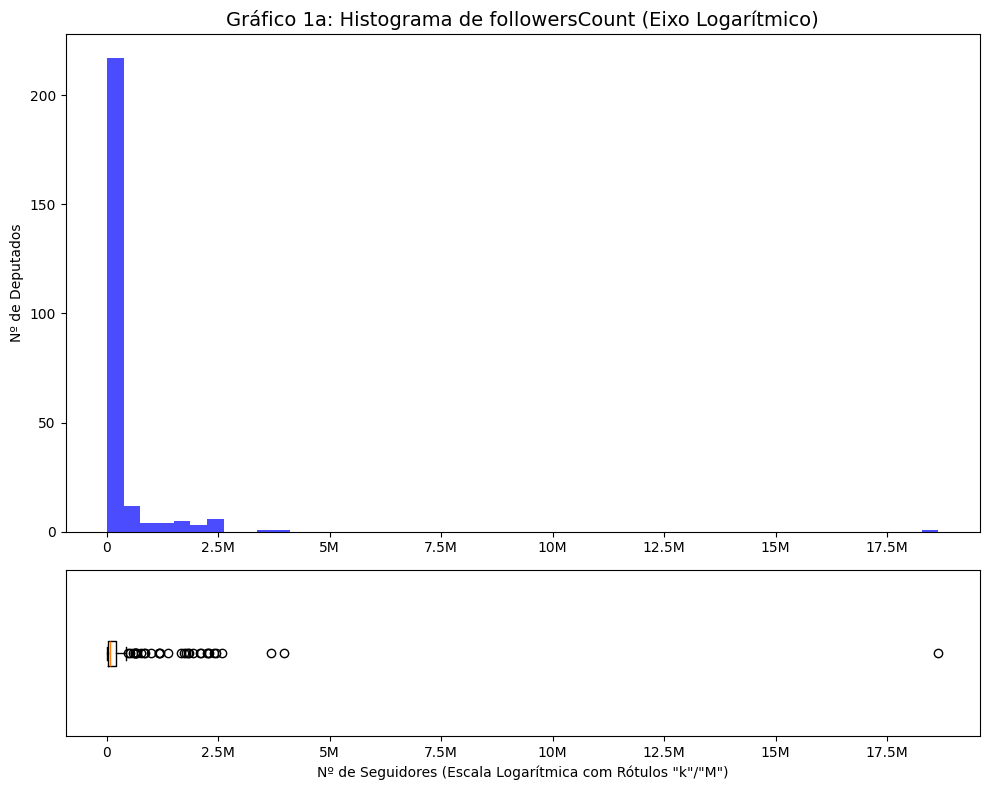

In [26]:
# --- Assumindo que 'followers_data' já foi carregado e filtrado ---
# Ex: df_plot = pd.read_csv('deputados.csv', sep=';').dropna(subset=['followersCount'])
#     followers_data = df_plot[df_plot['followersCount'] > 0]['followersCount']
# ------------------------------------------------------------------

# --- Início da Solução ---

# 1. Crie uma função para formatar os ticks (rótulos do eixo)
def reformat_large_ticks(tick_val, pos):
    """
    Converte um número em uma string 'k' (mil) ou 'M' (milhão).
    """
    if tick_val >= 1_000_000:
        val = tick_val / 1_000_000
        # Formata como '1M', '1.5M' etc., se não for um inteiro
        return f'{val:g}M'
    elif tick_val >= 1_000:
        val = tick_val / 1_000
        # Formata como '1k', '1.5k' etc.
        return f'{val:g}k'
    else:
        return f'{tick_val:g}'

# 2. Crie o formatador
human_readable_formatter = mticker.FuncFormatter(reformat_large_ticks)

# --- PLOT 1: HISTOGRAMA E BOXPLOT (COM FORMATAÇÃO HUMANA) ---
print("\nGerando Plot 1: Desigualdade (Histograma e Boxplot)...")

fig1, (ax_hist, ax_box) = plt.subplots(2, 1, figsize=(10, 8), 
                                     gridspec_kw={'height_ratios': [3, 1]})

# --- Histograma ---
ax_hist.hist(followers_data, bins=50, alpha=0.7, color='blue')
# A escala logarítmica é essencial para esta visualização
#ax_hist.set_xscale('log') 
ax_hist.set_title('Gráfico 1a: Histograma de followersCount (Eixo Logarítmico)', fontsize=14)
ax_hist.set_ylabel('Nº de Deputados')

# APLICA A NOVA FORMATAÇÃO AQUI
ax_hist.xaxis.set_major_formatter(human_readable_formatter)
# Oculta os rótulos menores entre os ticks principais
ax_hist.xaxis.set_minor_formatter(mticker.NullFormatter())


# --- Boxplot (horizontal) ---
ax_box.boxplot(followers_data, vert=False)
# A escala logarítmica é essencial
#ax_box.set_xscale('log') 
ax_box.set_xlabel('Nº de Seguidores (Escala Logarítmica com Rótulos "k"/"M")')
ax_box.set_yticks([]) # Remover o eixo Y do boxplot

# APLICA A NOVA FORMATAÇÃO AQUI
ax_box.xaxis.set_major_formatter(human_readable_formatter)
# Oculta os rótulos menores entre os ticks principais
ax_box.xaxis.set_minor_formatter(mticker.NullFormatter())


plt.tight_layout()
plt.savefig(settings.PLOT_1) # Salva o gráfico
plt.show(fig1) # Mostra o gráfico

O Gráfico 1, composto por um histograma (1a) e um boxplot (1b), fornece um diagnóstico visual inequívoco da distribuição da variável `followersCount` (Número de Seguidores) entre os 254 deputados federais analisados. O achado central, e estatisticamente mais relevante, é a **desigualdade extrema** na distribuição de capital político-digital. Esta visualização confirma de forma contundente a assimetria positiva (à direita) que foi identificada anteriormente nas estatísticas descritivas (onde a média de 351k é vastamente superior à mediana de 69k).

A primeira decisão metodológica na construção deste gráfico — o uso de uma **escala logarítmica** no eixo X — é, por si só, uma conclusão analítica. Uma escala logarítmica é necessária quando a amplitude dos dados é tão vasta (abrangendo múltiplas ordens de magnitude, do mínimo de ~6k ao máximo de ~18M) que, em uma escala linear, a grande maioria dos dados se aglomeraria em uma única barra indistinta à esquerda, tornando a visualização inútil. A necessidade desta escala prova que a diferença entre os perfis de menor e maior audiência não é apenas grande, mas exponencial.

O **Gráfico 1a (Histograma)** ilustra a frequência da distribuição. Nele, observamos que o "corpo" da amostra, ou seja, a grande maioria dos deputados, está concentrado nas faixas de audiência mais baixas. As barras mais altas do histograma situam-se claramente entre 10k e 100k seguidores. A partir de 100k, a frequência (Nº de Deputados) cai drasticamente, formando uma "cauda longa" que se estende para a direita. Esta cauda representa os poucos perfis "superstars" nas faixas de 1M (1 milhão) e 10M (10 milhões). O histograma demonstra visualmente que a mediana (o ponto que divide a amostra ao meio) está localizada dentro desse aglomerado inicial, enquanto a média é "puxada" para a direita por esta cauda longa, sendo estatisticamente inflada pelos poucos perfis de altíssima performance.

O **Gráfico 1b (Boxplot)** complementa essa análise de forma ainda mais precisa, resumindo a distribuição em quartis. O boxplot torna a desigualdade explícita:

1.  **A "Caixa" (O Intervalo Interquartil - IIQ):** A caixa, que contém os 50% centrais dos deputados (de Q1 a Q3), é notavelmente compacta e situada inteiramente na faixa esquerda do gráfico (aproximadamente entre 32k e 204k, com base nas estatísticas anteriores). Isso significa que metade de todos os parlamentares possui uma audiência que varia dentro desta faixa relativamente estreita.
2.  **A Mediana (Linha Central):** A linha dentro da caixa (a mediana, ~69k) está posicionada mais próxima de Q1 do que de Q3, confirmando a assimetria positiva.
3.  **Os "Outliers" (Pontos Individuais):** O achado visual mais impactante do boxplot são os numerosos pontos à direita da "caixa" e de seu "bigode" (whisker). Cada ponto representa um deputado que é considerado um *outlier* estatístico.

Visualmente, os dados não representam um universo coeso, mas sim dois grupos distintos: a "massa" de deputados (representada pela caixa compacta) e a "elite" de superstars digitais (representada pelos outliers). O boxplot prova que os perfis com mais de (aproximadamente) 500k-600k seguidores não são apenas "populares"; eles são estatisticamente anômalos em relação ao corpo principal da Câmara. Para fins de análise e estratégia de comunicação, tratar a "média" de seguidores (351k) como um valor representativo do deputado "típico" é um erro estatístico grave. O deputado "típico" está na mediana (~69k), e qualquer estratégia deve partir da segmentação clara entre a "massa" e os "outliers".

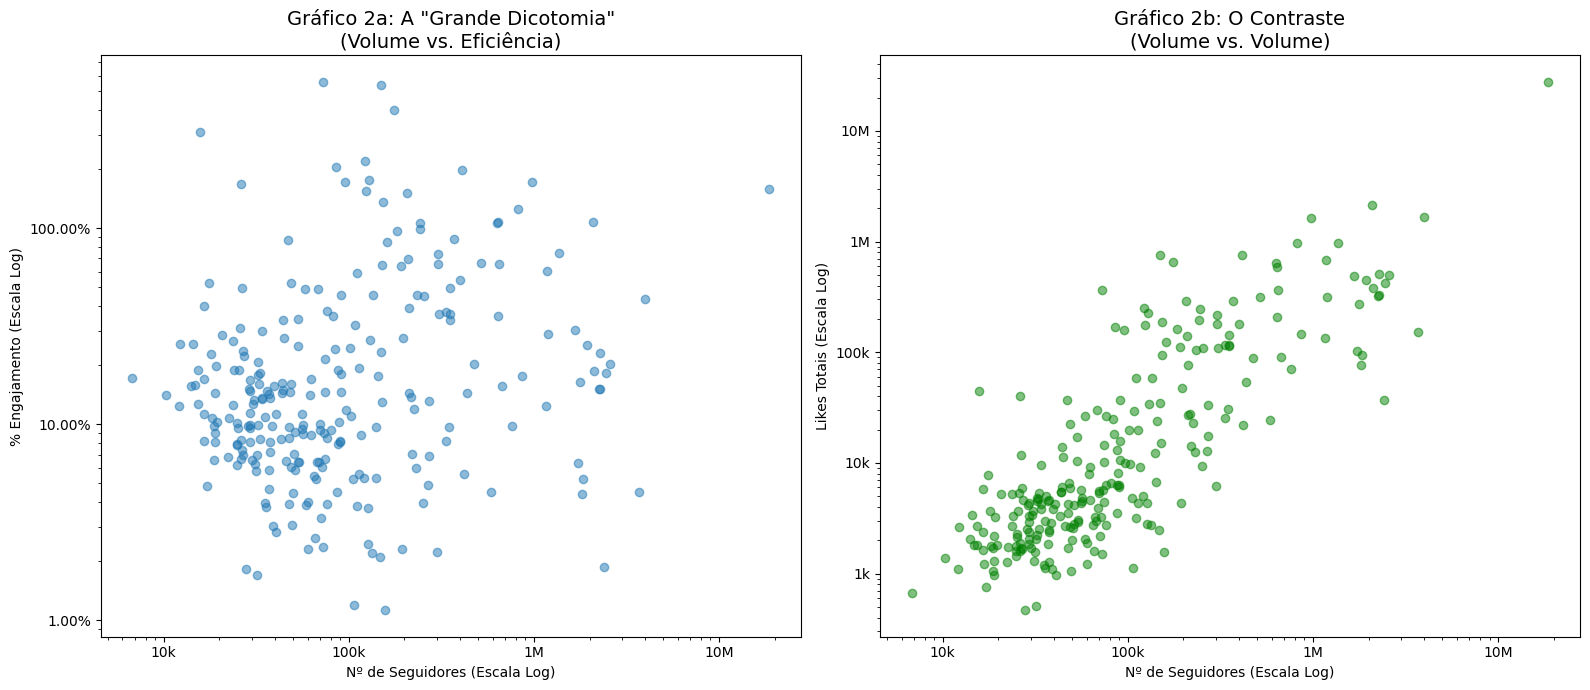

In [30]:
# --- Assumindo que 'df_plot' já foi carregado e limpo ---
# Ex: df_plot = pd.read_csv('deputados.csv', sep=';').dropna(subset=colunas_plotagem)
# ------------------------------------------------------------------

# 2. Crie os formatadores
# Formatador para números grandes (k, M)
human_readable_formatter = mticker.FuncFormatter(reformat_large_ticks)
# Formatador para porcentagem
percent_formatter = mticker.FuncFormatter(lambda y, _: '{:.2%}'.format(y))

# --- Início da Solução para o PLOT 2 ---

fig2, (ax_dicotomia, ax_contraste) = plt.subplots(1, 2, figsize=(16, 7))

# Filtrar dados > 0 para todos os eixos logarítmicos
df_plot_dicotomia = df_plot[(df_plot['followersCount'] > 0) & (df_plot['% Engajamento'] > 0)].copy()
df_plot_contraste = df_plot[(df_plot['followersCount'] > 0) & (df_plot['likesCount'] > 0)].copy()

# --- Gráfico 2a: A Dicotomia (Volume vs. Eficiência) ---
ax_dicotomia.scatter(df_plot_dicotomia['followersCount'], df_plot_dicotomia['% Engajamento'], alpha=0.5)

# Reative as escalas logarítmicas (ESSENCIAL)
ax_dicotomia.set_xscale('log')
ax_dicotomia.set_yscale('log')

ax_dicotomia.set_title('Gráfico 2a: A "Grande Dicotomia"\n(Volume vs. Eficiência)', fontsize=14)
ax_dicotomia.set_xlabel('Nº de Seguidores (Escala Log)')
ax_dicotomia.set_ylabel('% Engajamento (Escala Log)')

# Aplique a formatação "k/M" ao eixo X (Seguidores)
ax_dicotomia.xaxis.set_major_formatter(human_readable_formatter)
ax_dicotomia.xaxis.set_minor_formatter(mticker.NullFormatter()) # Limpa ticks menores

# Aplique a formatação de "%" ao eixo Y (Engajamento)
ax_dicotomia.yaxis.set_major_formatter(percent_formatter)
ax_dicotomia.yaxis.set_minor_formatter(mticker.NullFormatter()) # Limpa ticks menores


# --- Gráfico 2b: O Contraste (Volume vs. Volume) ---
ax_contraste.scatter(df_plot_contraste['followersCount'], df_plot_contraste['likesCount'], alpha=0.5, color='green')

# Reative as escalas logarítmicas (ESSENCIAL)
ax_contraste.set_xscale('log')
ax_contraste.set_yscale('log')

ax_contraste.set_title('Gráfico 2b: O Contraste\n(Volume vs. Volume)', fontsize=14)
ax_contraste.set_xlabel('Nº de Seguidores (Escala Log)')
ax_contraste.set_ylabel('Likes Totais (Escala Log)')

# Aplique a formatação "k/M" ao eixo X (Seguidores)
ax_contraste.xaxis.set_major_formatter(human_readable_formatter)
ax_contraste.xaxis.set_minor_formatter(mticker.NullFormatter())

# Aplique a formatação "k/M" também ao eixo Y (Likes)
ax_contraste.yaxis.set_major_formatter(human_readable_formatter)
ax_contraste.yaxis.set_minor_formatter(mticker.NullFormatter())


plt.tight_layout()
plt.savefig(settings.PLOT_2) # Salva o gráfico
plt.show(fig2) # Mostra o gráfico

O Gráfico 2 apresenta uma visualização comparativa fundamental para o diagnóstico estratégico do desempenho digital dos deputados. Ele é composto por dois gráficos de dispersão (scatter plots) que, juntos, expõem a "Grande Dicotomia" entre "Volume de Audiência" e "Eficiência de Engajamento". A utilização da escala logarítmica em todos os eixos é metodologicamente crucial para permitir a comparação entre perfis de ordens de magnitude tão diferentes (de 10k a mais de 10M de seguidores).

### Gráfico 2a (Esquerda): A "Grande Dicotomia" (Volume vs. Eficiência)

Este gráfico é o *insight* estratégico central da análise. Ele plota o "Nº de Seguidores" (Eixo X) contra o "% Engajamento" (Eixo Y), que representa a relação entre o volume total de interações acumuladas (likes + comentários) e a base de seguidores.

O resultado visual é uma **"nuvem de pontos" dispersa** (um "tiro de espingarda"), sem qualquer padrão linear claro. Isso é a prova visual da correlação estatística quase nula (r = 0.113) entre as duas métricas.

**Interpretação Estratégica:**
1.  **Ter mais seguidores não implica melhor engajamento:** A ausência de uma linha ascendente clara demonstra que o crescimento da audiência não se traduz, de forma alguma, em uma *taxa* de engajamento melhor.
2.  **Segmentação Clara:** O gráfico revela visualmente os segmentos que identificamos nos quadrantes:
    * **Canto Inferior Direito:** Vemos claramente pontos com audiências massivas (>1M de seguidores) mas com taxas de engajamento (`% Engajamento`) muito baixas (inferiores a 0.20, ou 20%). Estes são os "Gigantes Adormecidos".
    * **Canto Superior Esquerdo:** Observamos perfis com audiências modestas (<100k seguidores) que alcançam taxas de engajamento extraordinariamente altas (acima de 1.0, ou 100%). Estes são os "Perfis de Nicho" de alta eficiência.
3.  **Interpretação do Eixo Y:** Como definido, o valor de "100.00%" (ou 1.0) no eixo Y significa que o *volume total* de interações acumuladas no período foi igual à base de seguidores. Os pontos acima desta linha são perfis hiper-eficientes que geraram um volume de interação total superior ao seu número de seguidores.

### Gráfico 2b (Direita): O Contraste (Volume vs. Volume)

Este gráfico serve como um contraponto crucial. Ele plota o "Nº de Seguidores" (Eixo X) contra o "Likes Totais" (Eixo Y). Em nítido contraste com o gráfico 2a, aqui vemos um **padrão linear positivo muito forte**. Os pontos agrupam-se firmemente ao longo de uma linha diagonal que sobe da esquerda para a direita.

**Interpretação Estratégica:**
Este gráfico confirma visualmente a forte correlação positiva (r = 0.920) entre as duas métricas de volume. A conclusão é direta: **mais seguidores geram, sim, mais *volume* de curtidas.** Perfis com 1M de seguidores geram ordens de magnitude mais curtidas brutas do que perfis com 10k.

### Conclusão Combinada: O Diagnóstico Estratégico

Colocar os gráficos 2a e 2b lado a lado é o que solidifica a tese central da análise. O Gráfico 2b mostra que a estratégia de "Notoriedade" (focar em ganhar seguidores) é eficaz para gerar "Volume" (alcance bruto, curtidas brutas). Contudo, o Gráfico 2a prova que esta mesma estratégia é **ineficaz** para gerar "Eficiência" (uma *taxa* de engajamento alta).

A análise visual demonstra que "Volume" e "Eficiência" são dois eixos de desempenho independentes e não correlacionados. O desempenho digital dos deputados não pode ser medido por uma única métrica; ele deve ser avaliado nesta matriz bidimensional de (Audiência vs. Engajamento), exatamente como o Gráfico 3 (Quadrantes Estratégicos) propõe fazer.

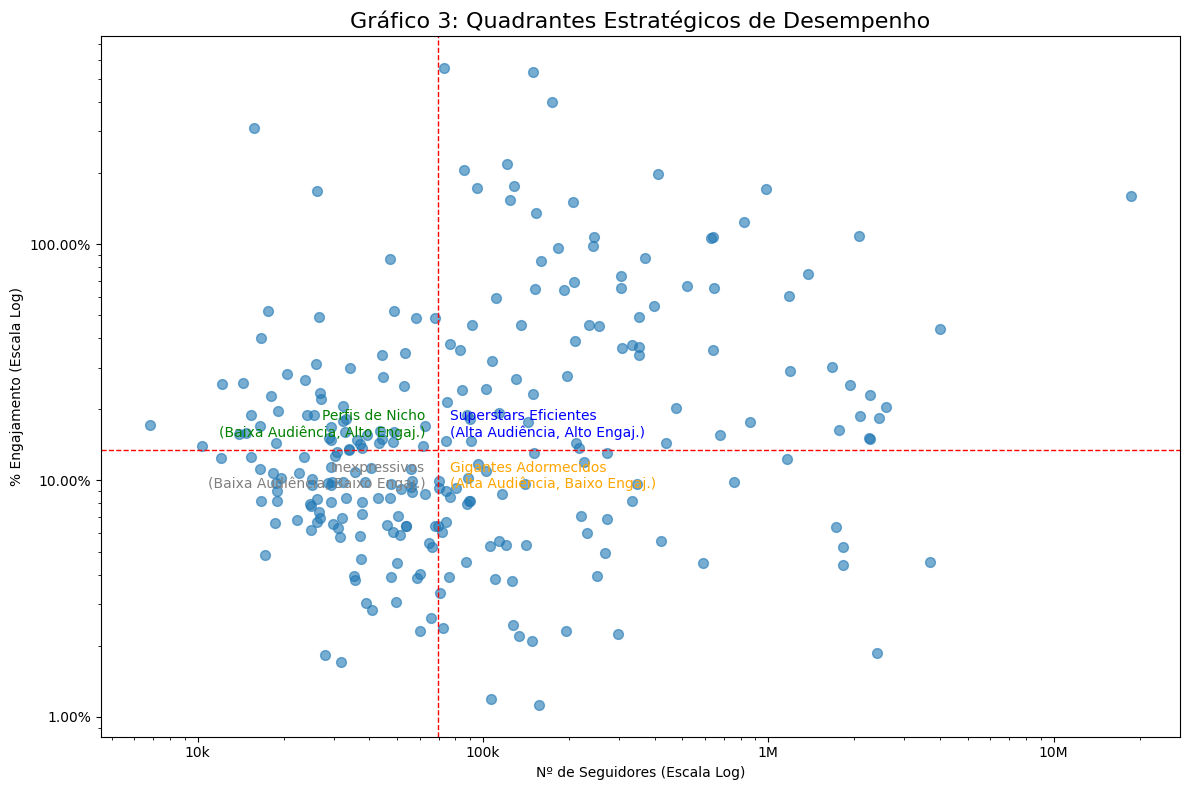

In [31]:
# (Contexto: Assumindo que df_plot_dicotomia foi criado em uma etapa anterior)
# Ex: df_plot = pd.read_csv('deputados.csv', sep=';').dropna(subset=['followersCount', '% Engajamento'])
#     df_plot_dicotomia = df_plot[(df_plot['followersCount'] > 0) & (df_plot['% Engajamento'] > 0)].copy()
# ------------------------------------------------------------------

# 2. Crie os formatadores necessários
human_readable_formatter = mticker.FuncFormatter(reformat_large_ticks)
percent_formatter = mticker.FuncFormatter(lambda y, _: '{:.2%}'.format(y))

# --- Início do Código do PLOT 3 (Corrigido) ---

plt.figure(figsize=(12, 8))

# Usar os mesmos dados filtrados do plot 2a
df_plot_quadrantes = df_plot_dicotomia.copy()

# Calcular medianas para dividir os quadrantes
median_followers = df_plot_quadrantes['followersCount'].median()
median_engagement = df_plot_quadrantes['% Engajamento'].median()

# Plotar o scatter plot
plt.scatter(df_plot_quadrantes['followersCount'], df_plot_quadrantes['% Engajamento'], alpha=0.6, s=50)
plt.xscale('log')
plt.yscale('log')

# Adicionar linhas de mediana
plt.axvline(median_followers, color='red', linestyle='--', linewidth=1)
plt.axhline(median_engagement, color='red', linestyle='--', linewidth=1)

# Adicionar texto para os quadrantes
plt.text(median_followers * 1.1, median_engagement * 1.1, 
         'Superstars Eficientes\n(Alta Audiência, Alto Engaj.)', 
         color='blue', ha='left', va='bottom', fontsize=10)
plt.text(median_followers * 0.9, median_engagement * 1.1, 
         'Perfis de Nicho\n(Baixa Audiência, Alto Engaj.)', 
         color='green', ha='right', va='bottom', fontsize=10)
plt.text(median_followers * 0.9, median_engagement * 0.9, 
         'Inexpressivos\n(Baixa Audiência, Baixo Engaj.)', 
         color='gray', ha='right', va='top', fontsize=10)
plt.text(median_followers * 1.1, median_engagement * 0.9, 
         'Gigantes Adormecidos\n(Alta Audiência, Baixo Engaj.)', 
         color='orange', ha='left', va='top', fontsize=10)

plt.title('Gráfico 3: Quadrantes Estratégicos de Desempenho', fontsize=16)
plt.xlabel('Nº de Seguidores (Escala Log)')
plt.ylabel('% Engajamento (Escala Log)')

ax = plt.gca() # Obter o eixo atual

# --- ALTERAÇÃO APLICADA AQUI ---
# Aplicar a formatação "k/M" ao eixo X (Seguidores)
ax.xaxis.set_major_formatter(human_readable_formatter)
ax.xaxis.set_minor_formatter(mticker.NullFormatter()) # Limpa ticks menores
# --- FIM DA ALTERAÇÃO ---

# Manter a formatação de % no eixo Y
ax.yaxis.set_major_formatter(percent_formatter)
ax.yaxis.set_minor_formatter(mticker.NullFormatter()) # Adicionado para limpeza

plt.tight_layout()
plt.savefig(settings.PLOT_3) # Salva o gráfico
plt.show() # Mostra o gráfico

O Gráfico 3, "Quadrantes Estratégicos de Desempenho", é a aplicação prática e estratégica das descobertas dos gráficos anteriores. Ele utiliza a mesma base de dados do Gráfico 2a (Nº de Seguidores vs. % Engajamento), mas vai além da simples constatação da "Grande Dicotomia" (a falta de correlação) e aplica um modelo de segmentação para classificar cada um dos 254 deputados em um de quatro perfis de desempenho distintos.

Metodologicamente, o gráfico é dividido por duas linhas de referência (em vermelho tracejado) que representam as **medianas** — e não as médias. A linha vertical representa o deputado mediano em `followersCount` (~69k), e a linha horizontal representa o deputado mediano em `% Engajamento` (~0.13 ou 13%). A escolha da mediana é estatisticamente robusta, pois, como vimos no Gráfico 1, a média é distorcida por outliers, enquanto a mediana representa o verdadeiro "ponto central" da amostra (50% dos deputados estão acima, 50% abaixo).

Esta divisão cria quatro segmentos estratégicos claros:

1.  **Quadrante Inferior Esquerdo ("Inexpressivos"):** Este quadrante contém os deputados que estão **abaixo da mediana** tanto em audiência (`followersCount`) quanto em eficiência (`% Engajamento`). Visualmente, este é o quadrante mais denso, confirmando que a maioria dos parlamentares se enquadra nesta categoria. São perfis com baixo alcance e baixa capacidade de gerar interação relativa, servindo como a linha de base de desempenho.

2.  **Quadrante Inferior Direito ("Gigantes Adormecidos"):** Este grupo é de alta importância estratégica. São deputados com **alta audiência** (acima da mediana de seguidores), mas com **baixa eficiência** (abaixo da mediana de engajamento). Eles possuem o "capital" (alcance, notoriedade), mas não conseguem "monetizá-lo" em forma de interação. Representam uma oportunidade significativa perdida: seu desafio não é crescer, mas sim criar conteúdo ressonante e gerenciar sua comunidade para ativar a base de seguidores que já possuem.

3.  **Quadrante Superior Esquerdo ("Perfis de Nicho"):** Este grupo é a prova viva da "Grande Dicotomia". São deputados com **baixa audiência** (abaixo da mediana de seguidores), mas que alcançam uma **alta eficiência** de engajamento (acima da mediana). Eles demonstram que não é preciso ter uma audiência massiva para gerar uma interação de alta qualidade. Sua estratégia de conteúdo é claramente eficaz para a comunidade que possuem. O desafio estratégico para este grupo é o *crescimento* de audiência, para que sua mensagem eficiente possa atingir mais pessoas.

4.  **Quadrante Superior Direito ("Superstars Eficientes"):** Este é o quadrante de elite. Contém os deputados que estão **acima da mediana** em *ambos* os eixos: possuem alta audiência e alta eficiência. Eles representam o cenário ideal, onde o grande alcance é combinado com uma capacidade comprovada de gerar interação. Estes perfis servem como *benchmarks* a serem estudados para entender como escalar uma audiência sem perder a qualidade da interação.

Este gráfico transforma a análise estatística de um "o quê" (os dados são assimétricos e não correlacionados) para um "e daí?" (e por isso, devemos agir de formas diferentes). Ele funciona como um mapa de diagnóstico tático. Em vez de aplicar uma única estratégia de mídia social para todos os 254 deputados, este gráfico argumenta visualmente que são necessárias pelo menos quatro estratégias distintas, cada uma adaptada ao quadrante específico em que o deputado se encontra.

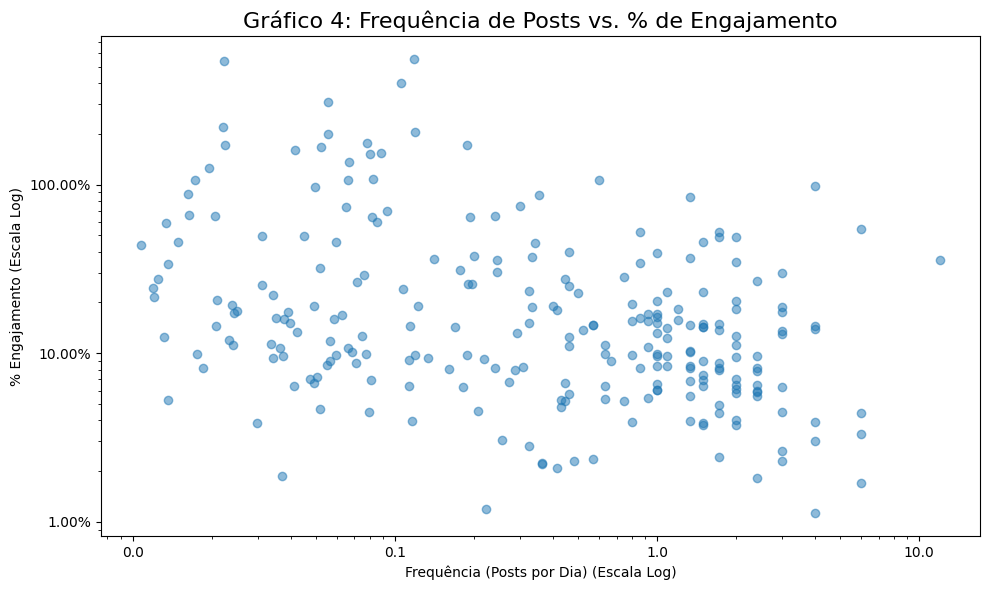

In [16]:
# --- 4. PLOT 4: INEFICÁCIA DA FREQUÊNCIA (Scatter Plot) ---
plt.figure(figsize=(10, 6))

# Filtrar dados > 0 para ambos os eixos
df_plot_frequencia = df_plot[(df_plot['Frequencia (Posts/Dia)'] > 0) & (df_plot['% Engajamento'] > 0)].copy()

# Plotar Frequência vs. % Engajamento
plt.scatter(df_plot_frequencia['Frequencia (Posts/Dia)'], df_plot_frequencia['% Engajamento'], alpha=0.5)
plt.xscale('log') # Eixo X logarítmico, pois Frequência também é assimétrica
plt.yscale('log') # Eixo Y logarítmico para melhor visualização

plt.title('Gráfico 4: Frequência de Posts vs. % de Engajamento', fontsize=16)
plt.xlabel('Frequência (Posts por Dia) (Escala Log)')
plt.ylabel('% Engajamento (Escala Log)')
ax = plt.gca() # Obter o eixo atual
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:.2%}'.format(y)))

plt.tight_layout()
plt.savefig(settings.PLOT_4)
plt.show()

O Gráfico 4, "Frequência de Posts vs. % de Engajamento", investiga uma das hipóteses táticas mais comuns na gestão de mídias sociais: a ideia de que "postar mais" leva a um "engajamento maior". Este gráfico de dispersão plota a `Frequencia (Posts/Dia)` (Eixo X) contra a métrica de eficiência, `% Engajamento` (Eixo Y), para testar essa relação.

A primeira observação, assim como nos gráficos anteriores, é o padrão visual dos dados. O gráfico exibe uma **"nuvem de pontos" amplamente dispersa**, sem qualquer tendência linear positiva clara. Se a hipótese de que "mais posts geram mais engajamento" fosse verdadeira, esperaríamos ver os pontos se agrupando ao longo de uma linha diagonal ascendente, da esquerda para a direita (onde mais posts/dia correspondessem a um maior % de engajamento). O gráfico mostra exatamente o oposto: **não há correlação positiva**.

Esta visualização é a prova gráfica da correlação fraca e levemente negativa (r = -0.170) que identificamos na análise estatística. A ausência de um padrão claro é, em si, a descoberta mais importante.

**Interpretação Estratégica:**
1.  **Desmistificação da Estratégia de Volume:** Este gráfico refuta diretamente a estratégia de "volume pelo volume". Podemos observar claramente pontos no extremo direito do eixo X (perfis que postam 2, 5 ou até 10+ vezes por dia) que possuem taxas de engajamento (`% Engajamento`) muito baixas, situando-se abaixo da mediana (linha de 0.13, ou 13%).
2.  **Validação da Estratégia de Qualidade:** Inversamente, vemos numerosos pontos no lado esquerdo do eixo X (perfis com baixa frequência, postando menos de uma vez a cada dois dias) que alcançam taxas de engajamento muito altas (acima de 1.0, ou 100%).
3.  **A Frequência não é um Predit_or_ de Eficiência:** A conclusão estatística é inequívoca: a frequência de publicação não é uma variável preditiva da *taxa* de engajamento. Aumentar o número de posts por dia não garante uma melhoria na eficiência da interação com a base de seguidores. Pelo contrário, a leve correlação negativa sugere que postar excessivamente pode, em alguns casos, levar a uma leve penalização no engajamento, possivelmente por saturar ou "cansa" a audiência.

**Conclusão Estratégica:**
Este gráfico fornece uma evidência estatística robusta para que os gestores de comunicação política foquem seus recursos não na *quantidade* de publicações, mas sim na *qualidade* e *ressonância* do conteúdo. A tática de aumentar a frequência de posts, como estratégia isolada, é ineficaz para melhorar a eficiência do engajamento. O desempenho da taxa de engajamento é determinado pelo que é postado, e não pela frequência com que se posta.

# Conclusões

A análise estatística aprofundada do desempenho no Instagram de 254 deputados federais revela um ecossistema digital complexo, definido por duas características centrais e interdependentes: a extrema heterogeneidade de desempenho e a "Grande Dicotomia" entre volume de audiência e eficiência de engajamento.

Nossa análise descritiva univariada (confirmada visualmente pelo Gráfico 1) foi o primeiro e mais importante diagnóstico. Em todas as métricas de desempenho principais (followersCount, likesCount, commentsCount, videoViewCount), a média aritmética é uma medida estatisticamente inútil e enganosa para representar o deputado "típico". A disparidade entre a média e a mediana (ex: média de 351k seguidores vs. mediana de 69k) é a prova de um "Efeito Superestrela": um pequeno grupo de perfis de altíssima performance (outliers estatísticos) concentra a vasta maioria do capital político-digital, enquanto a grande maioria dos parlamentares (representada pela mediana e pelo intervalo interquartil) opera com números modestos. Esta desigualdade extrema torna a segmentação uma necessidade analítica, não uma opção.

A segunda grande descoberta, proveniente da análise de correlação e visualizada nos Gráficos 2 e 3, é a "Grande Dicotomia". Demonstramos estatisticamente que os dois principais objetivos estratégicos no Instagram — Volume (Notoriedade) e Eficiência (Comunidade) — são eixos de desempenho independentes. A correlação quase perfeita entre followersCount e likesCount (Gráfico 2b) prova que a notoriedade gera volume bruto. Contudo, a correlação quase nula entre followersCount e % Engajamento (Gráfico 2a) prova que notoriedade *não* gera eficiência. O Gráfico 3 (Quadrantes Estratégicos) aplica esta descoberta, segmentando o universo de deputados em quatro grupos táticos claros ("Inexpressivos", "Gigantes Adormecidos", "Perfis de Nicho" e "Superstars Eficientes"), cada um exigindo uma estratégia de comunicação completamente distinta.

Finalmente, nossas análises refutaram táticas comumente aceitas. A análise do Gráfico 4 (Frequência vs. Engajamento) e a correlação negativa (r = -0.170) entre as duas métricas provam que a estratégia de "postar mais" não é apenas ineficaz para melhorar a taxa de engajamento, como pode ser levemente prejudicial. Da mesma forma, a correlação nula entre followsCount e followersCount sugere que a tática de "seguir em massa" é estatisticamente irrelevante para o crescimento. Concluímos também que o engajamento na plataforma é esmagadoramente passivo (mediana de 0,12% para % likesCount vs. 0,01% para % commentsCount), indicando que a geração de debate ativo (comentários) é um feito raro e restrito a uma elite de perfis.

Em suma, a performance digital na Câmara dos Deputados não é um jogo de "quantidade" (posts, seguidores), mas sim de "qualidade" (ressonância do conteúdo) e "posicionamento" (entender em qual quadrante estratégico o perfil se encaixa).

## Recomendações de Análises Estatísticas Avançadas

A análise exploratória de dados (AED) que conduzimos é a base fundamental. Para extrair insights preditivos e causais mais profundos, recomendo as seguintes análises estatísticas avançadas:

1.  Análise de Cluster (Cluster Analysis - K-Means):
    * O que é: Em vez de usarmos as medianas para criar 4 quadrantes "forçados" (como no Gráfico 3), usaríamos um algoritmo de *machine learning* não supervisionado (como o K-Means) para que os dados se agrupem "naturalmente".
    * Por quê: O algoritmo poderia identificar 5, 6 ou 7 perfis estratégicos distintos que não são visíveis a olho nu. Por exemplo, ele poderia encontrar um cluster de "Perfis de Mídia" (frequência altíssima, engajamento baixo) ou "Perfis de Polêmica" (taxa de comentários altíssima, mas audiência média). Isso refinaria nossa segmentação de forma muito mais precisa.

2.  Análise de Regressão Múltipla (Multiple Linear Regression):
    * O que é: Um modelo preditivo para responder à pergunta: "Qual é a fórmula para o engajamento?".
    * Por quê: A correlação apenas nos disse que Frequencia (Posts/Dia) *não* está relacionada ao % Engajamento. Uma regressão múltipla poderia nos dizer o que *está*. Criaríamos um modelo onde Y = % Engajamento e os fatores X seriam followersCount (para testar o "custo de escala"), Frequencia (Posts/Dia), e, crucialmente, % commentsCount. O modelo nos diria o "peso" exato de cada variável, quantificando, por exemplo, o quanto "gerar 1% a mais de comentários" impacta o engajamento geral, isolando os verdadeiros motores de desempenho.

3.  Análise de Componentes Principais (PCA) e Análise Fatorial:
    * O que é: Nossos dados possuem muitas variáveis que medem coisas semelhantes (ex: likesCount, commentsCount, videoViewCount são todas "volume").
    * Por quê: A PCA poderia "condensar" essas 13 variáveis em 3 ou 4 "Componentes Principais" (fatores latentes), como "Notoriedade Geral", "Eficiência de Interação" e "Nível de Atividade". Poderíamos então usar esses fatores, que são estatisticamente mais limpos, como base para os modelos de cluster ou regressão, tornando as conclusões ainda mais robustas.

4.  Análise de Sentimento e Tópicos (NLP) sobre os *Outliers*:
    * O que é: Esta é uma análise mista (quantitativa-qualitativa). Selecionaríamos os 10 melhores perfis do quadrante "Perfis de Nicho" (alta eficiência) e os 10 piores do "Gigantes Adormecidos" (baixa eficiência).
    * Por quê: A estatística nos diz *quem* está em cada grupo, mas não *por quê*. Uma análise de Processamento de Linguagem Natural (NLP) sobre o conteúdo (biografias, legendas dos posts) e os comentários desses perfis nos diria *o que* os perfis eficientes estão falando (temas, tom de voz) e *como* o público reage a eles (análise de sentimento dos comentários), fornecendo insights de conteúdo acionáveis.